#Classification

Classification is a form of supervised learning where the outcome is a discrete *class*. For example, a message in your inbox can be classified as *email* or *spam*. A handwritten digit recognizer outputs one of 10 possible classes, one for each digit (0-9).

Let's use machine learning to predict mortality of Intensive Care Unit (ICU) patients. The dataset we'll be looking at is from the [2012 PhysioNet/Computing in Cardiology challenge](http://physionet.org/challenge/2012/). It contains records of ICU stays longer than 48 hours. At the start of the stay, several static attributes such as age, gender and height are recorded for the patient. Then over the next 48 hours, various medical measurements are taken, some more than once. The outcome we want to predict is whether the patient survived or died in-hospital.

## Loading the Data

The raw dataset can be found on the challenge website linked above. However, for this tutorial, we did a little preprocessing for you, so we spend less time on data munging. If you want to know more about what we did, see the [Feature Engineering](#Feature-Engineering) section at the bottom of the tutorial.

We provide a [training set](https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/train-a.csv) and a [test set](https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/test-a.csv). The data is stored as a CSV, with a header labelling the attributes. Let's load the training set by using the `requests` library to download the file.

In [1]:
import requests
response = requests.get('https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/train-a.csv')
print response.status_code
raw_data = response.content

200


Because `csv.reader()` expects a file-like object as the argument, we wrap the downloaded data in a `StringIO` object, which provides the methods `csv.reader()` expects.

In [2]:
import csv
import StringIO

f = StringIO.StringIO(raw_data)
data = []
reader = csv.reader(f)
feature_names = reader.next()
for row in reader:
    row = [float(r) for r in row]
    data.append(row)

What kind of attributes do we have in our dataset? Let's print the header.

In [3]:
print feature_names

['ALP_diff', 'ALP_first', 'ALP_last', 'ALP_max', 'ALP_mean', 'ALP_min', 'ALT_diff', 'ALT_first', 'ALT_last', 'ALT_max', 'ALT_mean', 'ALT_min', 'AST_diff', 'AST_first', 'AST_last', 'AST_max', 'AST_mean', 'AST_min', 'Age', 'Albumin_diff', 'Albumin_first', 'Albumin_last', 'Albumin_max', 'Albumin_mean', 'Albumin_min', 'BUN_diff', 'BUN_first', 'BUN_last', 'BUN_max', 'BUN_mean', 'BUN_min', 'Bilirubin_diff', 'Bilirubin_first', 'Bilirubin_last', 'Bilirubin_max', 'Bilirubin_mean', 'Bilirubin_min', 'Cholesterol_diff', 'Cholesterol_first', 'Cholesterol_last', 'Cholesterol_max', 'Cholesterol_mean', 'Cholesterol_min', 'Creatinine_diff', 'Creatinine_first', 'Creatinine_last', 'Creatinine_max', 'Creatinine_mean', 'Creatinine_min', 'DiasABP_diff', 'DiasABP_first', 'DiasABP_last', 'DiasABP_max', 'DiasABP_mean', 'DiasABP_min', 'FiO2_diff', 'FiO2_first', 'FiO2_last', 'FiO2_max', 'FiO2_mean', 'FiO2_min', 'GCS_diff', 'GCS_first', 'GCS_last', 'GCS_max', 'GCS_mean', 'GCS_min', 'Gender', 'Glucose_diff', 'Gluc

Whoa, that's a lot of variable names! Let's take a closer look. We have fields like `Age`, `Gender`, `ICUType` and `Height`, which only have one value, and then we have a bunch of fields with `FIELDNAME_min`, `FIELDNAME_max`, `FIELDNAME_mean`, etc. This is how we decided to handle the time series measurements. For each medical metric, we computed the min, max, mean, first value, last value and difference between first and last values as a way to represent measurements over time. That's why there are so many fields! The medical measurements themselves are explained in more detail on the [Physionet website](http://physionet.org/challenge/2012/).

The outcome is the last field: `In-hospital_death`. 1 means the patient died in the hospital. 0 means the patient survived.

Not all of the metrics were measured for each patient. Missing values are represented by -1. All recorded values are nonnegative.

Let's separate the features from the outcome and store them in `numpy` arrays. `numpy` is a library useful for scientific computing, and it defines array objects for storing scientific data, as well as many mathematical functions. `scikit-learn`, the Python machine learning library we'll be using in this tutorial, is designed to work well with data in `numpy` arrays.

In [26]:
import numpy
X = numpy.array([f[0:-1] for f in data])  # features
y = numpy.array([f[-1] for f in data])  # labels

## Understanding the Data

How do we begin understanding our dataset? A good place to start is by measuring the proportion of positive outcomes. The proportion of positive outcomes is just the mean of the labels, since labels are either 0 or 1. Since we put our data into numpy arrays, we can take advantage of some [very useful methods on arrays](http://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

In [27]:
print y.mean()

0.145625


The proportion is fairly low (as would hopefully be expected with modern medicine!).

Let's use [matplotlib](http://matplotlib.org/api/) and the [histogram function](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist) to visualize some of the features.

The following line enables IPython's matplotlib mode.

In [6]:
%matplotlib inline

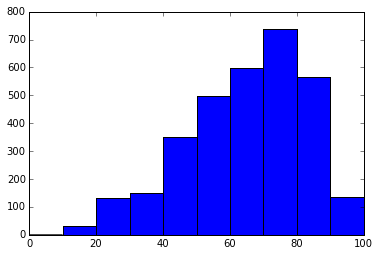

In [8]:
import matplotlib.pyplot as plt

age_idx = feature_names.index('Age')  # Get the index of the 'Age' column.
ages = X[:, age_idx]  # Extract the 'Age' column.

n, bins, patches = plt.hist(ages, bins=10, range=(0,100))
plt.show()

As would be expected, the histogram peaks at an older age (75).

___
**Exercise:** Can you plot the histogram of another feature? Hint: if you remove the `bins` and `range` keyword arguments to `plt.hist`, it automatically finds a reasonable set of bins for your data.
___

## Building a Model

`Scikit-learn` uses a common API for all of their machine learning models, which makes it really easy to try different models. Let's start with a simple [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**NOTE** A logistic regression model is *not* used for regression -- it is used for *classification*. Confusing! It's naming comes from the fact that it uses a linear model (similar to linear regression) to map the inputs to outputs. However, it then passes the output through a function (the logit function) which caps the value from 0 to 1, and increases the steepness of the curve around the midpoint - the image below plots the logit function. This allows the model to be used for classification.

<img src="http://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg" width="30%" height="30%"></img>

First, we'll split the dataset into a train and test set, with 80% used for training.

In [10]:
TRAIN_SIZE = int(0.8 * len(X))
print '# in training set:', num_train
X_train = X[:TRAIN_SIZE]
y_train = y[:TRAIN_SIZE]
X_test = X[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]

# in training set: 2560


Because logistic regression is based on a linear model, it won't handle missing values represented by -1 very well. Scikit-learn has an `Imputer` class that provides basic strategies for filling in, or *imputing*, missing values. Let's use the strategy of using the mean of the known values to replace the missing values.

In [11]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=-1, strategy='mean')
X_train_imputed = imp.fit_transform(X_train)

Linear models are also sensitive to different ranges for input features. For example, if one input features has a range of -1 to 1 and another has a range of 0 to 100, the feature with the larger range will disproportionately influence the model. (TODO: verify?) To combat this, we scale all the features to **zero mean and unit variance**, using scikit-learn's `StandardScaler` class.

Note: We filled in missing values before scaling, otherwise the number used to represent missing values would distort the scaling.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

Ok, now we're ready to train the model. Scikit-learn's models all have a `fit()` function to fit the model to the training data and a `predict()` function to predict the outcome on new input data.

In [13]:
from sklearn import linear_model
model = linear_model.LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

## Evaluating a Model
Now that we have a model, how do we tell how good it is? Since we have labelled outcomes to compare predictions to, we can quantitatively measure how well the model is doing. This is where we use the test set. Because we only used the training set to develop the model, we can use the test set to see how well the model works on unseen data. With classification, each outcome is either predicted correctly or not, so the measure of success is binary.

Models in scikit-learn usually have a `score()` method, which takes in a set of features and their labels. For logistic regression, this method returns the **accuracy** of the model on the input data. Accuracy is the number of outcomes correctly predicted divided by the total number of outcomes.

In [14]:
X_test_scaled = scaler.transform(imp.transform(X_test))
model.score(X_test_scaled, y_test)

0.85624999999999996

Remember from before that the proportion of positive outcomes is fairly low. This means that accuracy is not necessarily a very useful metric of model performance. A model which predicts survival for each patient (a negative outcome) would still be ~86% accurate! Thankfully, there are other metrics for model performance. Before we go into these metrics, let's define a few terms. In binary classification, there is a **positive** outcome and a **negative** outcome. Typically, the positive outcome is the case you'd like to detect (ex. detecting a malignant tumor, or detecting spam), and the negative outcome is the more normal, generally expected outcome (ex. not a tumor, or is email). In our example, the positive outcome is an in-hospital death. The prediction results can be one of the following:
* **true positive**: a correctly predicted positive outcome
* ** false positive**: a negative outcome incorrectly predicted as positive
* ** true negative**: a correctly predicted negative outcome
* ** false negative**: a positive outcome incorrectly predicted as negative

Let's now apply these terms to other metrics for model performance:
* **recall**, also known as **sensitivity**: of the patients who died, how many did we predict correctly. This is the number of true positives over the total number of positives.
* **precision**, also known as **positive predictivity**: of the patients we predicted positive, what fraction was correct. This is the number of true positives over the total number we predicted as positive.

One method of visualizing these metrics is to plot the precision-recall curve. As precision goes down, recall tends to go up. For example, we can achieve 100% recall if we predict everyone as positive, but this means our precision is 14.5% (the proportion of true positives).

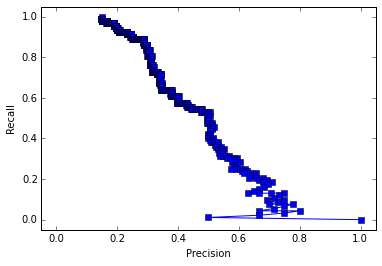

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

predicted_probs = model.predict_proba(X_test_scaled)
precision, recall, thresholds = precision_recall_curve(y_test, predicted_probs[:,1])
plt.plot(precision, recall, 's-', lw=1)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

One measure of model performance (and the method used in the Physionet challenge) is the minimum of precision and recall. One would pick the point in the curve that maximizes this value.

In [16]:
both = zip(precision, recall)
print 'Max min of P/Se', max([min(r) for r in both])

Max min of P/Se 0.505376344086


Another commonly used metric in classification is the **Receiver Operating Characteristic (ROC) curve**. This curve plots the recall/sensitivity (also known as **True Positive Rate**) vs. the false positive rate:
* **false positive rate**: number of false positives over the total number of negatives.

AUC 0.821792684862


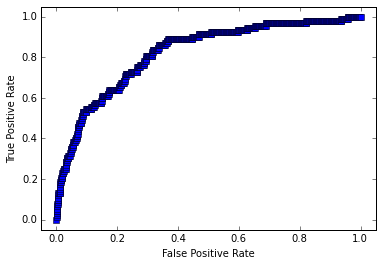

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
print 'AUC', roc_auc_score(y_test, predicted_probs[:,1])

fpr, tpr, thresholds = roc_curve(y_test, predicted_probs[:,1])
plt.plot(fpr, tpr, 's-', lw=1)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

A perfect predictor would have a true positive rate of 1 while the false positive rate is 0. In general, we want to maximize the area under the ROC curve. The greater the area, the better performing the model is. `sklearn` has a function [`roc_auc_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) that computes the area under the curve (AUC).
___
**Exercise:** If I can only tolerate a false positive rate of 20% (maybe I have limited hospital resources), what is the maximum recall I can achieve with the logistic regression model?
___
**Exercise:** Try using a [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) instead of a logistic regression model. A random forest model averages the result of many decision trees trained on random subsets of the data. How do the results compare? What if you increase the number of estimators (the number of trees in the forest)? 
___

## Model Selection

The logistic regression model takes in a hyperparameter *C* that controls the regularization. Regularization is the method of introducing constraints to a solution to prevent overfitting. In logistic regression, the type of regularization used is usually a penalty on very large coefficients. *C* controls the amount of penalty incurred. So how do we pick the best *C* for our dataset? For that matter, how do we know logistic regression is even the model we should use?

Well, we can try all of the various possibilities and evaluate the solution on a test set. The model that gives the best results is the winner. However, we don't want to use our test set for this selection process because we then won't have any unseen data to make a final evaluation. We need a *third* partition to our dataset set to evaluate the model, referred to as the "validation set". Instead of creating a fixed third partition as the validation set, we usually choose to use the method of **cross-validation.** This uses different splits of the training set for train and evaluation.

Scikit-learn has a library of utilities for cross-validation and performance evaluation in the `sklearn.cross-validation` module. It has several classes which automatically generate different splits of the training set. We will be using the `StratifiedKFold` iterator, which splits the data into *n* folds. *n - 1* folds are used for training, and the *nth* fold is used for test. A stratified K-fold maintains approximately the same percentage of each outcome class in each fold as in the complete set.

Let's use the stratified K-fold method to create train/test splits and use the average of the results of the K folds to evaluate our model choice.

In [25]:
from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, 10)  # 10 = number of folds

max_P_Se_values = []
for train, test in skf:
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    
    imp = Imputer(missing_values=-1, strategy='mean')
    X_train_imputed = imp.fit_transform(X_train)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    model = linear_model.LogisticRegression()
    model.fit(X_train_scaled, y_train)
    X_test_scaled = scaler.transform(imp.transform(X_test))
    predicted_probs = model.predict_proba(X_test_scaled)
    precision, recall, thresholds = precision_recall_curve(y_test, predicted_probs[:,1])
    both = zip(precision, recall)
    max_P_Se = max([min(r) for r in both])
    print 'Max min of P/Se', max([min(r) for r in both])
    max_P_Se_values.append(max_P_Se)

print 'Mean value over 10 folds:', numpy.mean(max_P_Se_values)

Max min of P/Se 0.34328358209
Max min of P/Se 0.34693877551
Max min of P/Se 0.404255319149
Max min of P/Se 0.510638297872
Max min of P/Se 0.382978723404
Max min of P/Se 0.425531914894
Max min of P/Se 0.521739130435
Max min of P/Se 0.45652173913
Max min of P/Se 0.509803921569
Max min of P/Se 0.458333333333
Mean value over 10 folds: 0.436002473739


___

**Exercise:** Use Stratified K-fold to measure the performance of the random forest classifier.
___
**Exercise:** Use Stratified K-fold to measure the performance of logistic regression with C = 0.1. How about C = 0.01? (You can change C, which defaults to 1, by passing C as a parameter to the model: `linear_model.LogisticRegression(C=0.1)`.
___


We randomly tested a couple of values for C, but how do we actually find the best value of C? What if we had a *second* parameter *a*? Now the problem is even harder! The traditional method is [**grid search**](http://scikit-learn.org/stable/modules/grid_search.html), where you exhaustively try all the parameter combinations until the best model is found. More efficient methods have been developed over the years. Scikit-learn has several different implementations of parameter search algorithms in the [`sklearn.grid_search`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.grid_search) module.

## Evaluating on the Test Set

So far, we haven't touched the test set. This was intentional, so that you have a pristine dataset to test your final model on after we went through all the topics above. Try loading the data on your own from [https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/test-a.csv](https://raw.githubusercontent.com/lydiagu/ml-tutorial/master/physionet/test-a.csv) and evaluating your model!

## Feature Engineering

Raw data is not a nice csv. How did we preprocess the data?

We only used the training set from the challenge website because that's the only labelled dataset available to the public. We further split the challenge training set into a train and test set for this tutorial (`train-a.csv` and `test-a.csv`).

The featurization code can be found on [github](https://github.secureserver.net/lgu/techfest-ml-tutorial/blob/master/physionet/create_featurized_datasets.py). It both featurizes the dataset and splits it into train and test sets. Each patient record file is read and stored as a dictionary of metric name to list of measurements. Then for each metric name, we compute the min, max, mean, first value, last value and difference between first and last values. If no measurements were recorded for that metric, all of those features would be -1. 
